# Clusterting the Spatial Domain

In [3]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn


/project/DPDS/Xiao_lab/shared/qin_zhou/environments/envs/MicNet/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
### Read GT
file_GT='/project/DPDS/Xiao_lab/shared/qin_zhou/MicNet_revision/script_new/dataset3_breast/data/meta_data_with_annotation.csv'
GT_raw=pd.read_csv(file_GT, index_col=0)
GT_raw=GT_raw[['annotation']]
GT_raw

,annotation
0,
GTAGACAACCGATGAA-1,fat
ACAGATTAGGTTAGTG-1,fat
TGGTATCGGTCTGTAT-1,NaN
ATTATCTCGACAGATC-1,NaN
TGAGATCAAATACTCA-1,NaN
...,...
GCCCTGAGGATGGGCT-1,fibrous
CGGGCGATGGATCACG-1,fibrous
TGCGGACTTGACTCCG-1,fibrous


In [4]:
### Load the MicNet embedding

In [20]:
feat_images, feat_genes = torch.load("./output/3_IGC_breast_cancer_FFPE_all_indexes_features.pt")

image_feature = feat_images
gene_feature = feat_genes

In [24]:
# Concatenate features
MicNet_embedding_array=np.concatenate((image_feature, gene_feature), axis=1)

# Convert to DataFrame and add GT_raw index
MicNet_embedding = pd.DataFrame(MicNet_embedding_array, index=GT_raw.index)


In [25]:
import numpy as np
import pandas as pd

def run_clustering(method, embedding, index=None, label_name="label", fill_value=-1):
    """
    Run clustering with NaN-safe masking and return a DataFrame with cluster labels.

    Parameters
    ----------
    method : sklearn-like clustering object
        Must implement .fit() and provide .labels_ after fitting.
    embedding : np.ndarray or pd.DataFrame
        2D array of shape (n_samples, n_features). May contain NaNs.
    index : pd.Index or list-like, optional
        Index to assign to the returned DataFrame. If None, defaults to 0..n-1.
    label_name : str, optional
        Column name for cluster labels in the returned DataFrame.
    fill_value : int, optional
        Value to assign for rows with NaN embeddings (default=-1).

    Returns
    -------
    df : pd.DataFrame
        DataFrame with one column containing cluster labels as integers.
        Invalid rows get `fill_value`. Index matches `index` if provided.
    """
    # Mask for valid samples (no NaNs across features)
    mask_valid = ~np.any(np.isnan(embedding), axis=1)

    # Allocate integer array with fill_value
    Y = np.full(embedding.shape[0], fill_value, dtype=int)

    # Fit method only on valid rows
    Cluster = method.fit(embedding[mask_valid])

    # Assign cluster labels back
    Y[mask_valid] = Cluster.labels_.astype(int)

    # Return DataFrame with correct index
    if index is None:
        index = range(embedding.shape[0])
    return pd.DataFrame({label_name: Y}, index=index)


In [26]:
from sklearn.cluster import KMeans

n_clusters = 5
method = KMeans(init='k-means++', n_clusters=n_clusters, random_state=1)

# Run clustering on each embedding using the same `method`
MicNet_df        = run_clustering(method, MicNet_embedding.to_numpy(), MicNet_embedding.index, "label")


In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

# Ground truth
gt = GT_raw['annotation']

# Dictionary of prediction dataframes
pred_dfs = {
    "MicNet": MicNet_df,
}

# Store results
scores = {}

for name, df in pred_dfs.items():
    # pick the right label column
    if "label" in df.columns:
        Y = df['label'].to_numpy()
    elif "cluster" in df.columns:
        Y = df['cluster'].to_numpy()
    else:
        raise ValueError(f"{name} dataframe missing label column")

    # Masks: keep only samples with both predictions and GT
    mask_pred = pd.notna(Y)
    mask_gt   = gt.notna().to_numpy()
    mask_common = mask_pred & mask_gt

    y_true = gt.to_numpy()[mask_common]
    y_pred = Y[mask_common]

    # Encode both true and predicted labels as integers
    le_true = LabelEncoder()
    y_true_enc = le_true.fit_transform(y_true)

    le_pred = LabelEncoder()
    y_pred_enc = le_pred.fit_transform(y_pred)

    # Compute ARI and AMI
    ari = adjusted_rand_score(y_true_enc, y_pred_enc)
    ami = adjusted_mutual_info_score(y_true_enc, y_pred_enc)

    scores[name] = {"ARI": ari, "AMI": ami, "n_samples": mask_common.sum()}

# Print results
for name, score in scores.items():
    print(f"{name}: ARI={score['ARI']:.4f}, AMI={score['AMI']:.4f} (n={score['n_samples']})")


MicNet: ARI=0.5381, AMI=0.4611 (n=1337)


In [29]:
### Plot the figure

In [30]:
image_file = "./dataset/Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()

(25233, 27452, 3)


In [31]:
transformation_file =  "./dataset/Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
pd_meta

,Row,Col,X,Y,Spot_radius
0,,,,,
GTAGACAACCGATGAA-1,7,55,5406,13126,94
ACAGATTAGGTTAGTG-1,7,57,5407,13417,94
TGGTATCGGTCTGTAT-1,7,59,5407,13707,94
ATTATCTCGACAGATC-1,7,61,5407,13997,94
TGAGATCAAATACTCA-1,7,63,5407,14287,94
...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,68,74,20805,15869,94
CGGGCGATGGATCACG-1,69,75,21057,16013,94
TGCGGACTTGACTCCG-1,68,76,20805,16159,94


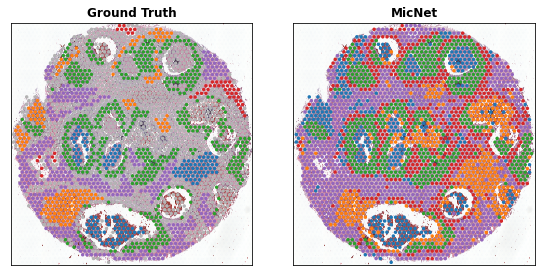

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# ----------------------------
# 0. relabel the order
# ----------------------------
def relabel_to_gt(pred_series, gt_series):
    """Relabel predicted clusters to GT labels using Hungarian matching."""
    df = pd.DataFrame({"pred": pred_series, "gt": gt_series}).dropna()
    pred_clusters = sorted(df["pred"].unique())
    gt_classes = sorted(df["gt"].unique())

    conf_mat = np.zeros((len(pred_clusters), len(gt_classes)))
    for i, pc in enumerate(pred_clusters):
        mask = df["pred"] == pc
        for j, gc in enumerate(gt_classes):
            conf_mat[i, j] = np.sum(df.loc[mask, "gt"] == gc)

    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    mapping = {pred_clusters[i]: gt_classes[j] for i, j in zip(row_ind, col_ind)}
    return pred_series.map(mapping)

# ----------------------------
# 1. Methods to show
# ----------------------------
methods = ["GT_annotation", "MicNet"]

n_rows, n_cols = 1, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

coords_x = pd_meta["Y"].values
coords_y = pd_meta["X"].values

# ----------------------------
# 2. Fixed GT palette
# ----------------------------
gt_labels = ['necrosis', 'immune', 'invasive', 'fat', 'fibrous', 'undefined']
gt_palette = {
    'necrosis': sns.color_palette("tab10")[0],
    'immune': sns.color_palette("tab10")[1],
    'invasive': sns.color_palette("tab10")[2],
    'fat': sns.color_palette("tab10")[3],
    'fibrous': sns.color_palette("tab10")[4],
    'undefined': (0.7, 0.7, 0.7)
}

# ----------------------------
# 3. Plot
# ----------------------------
for i, method in enumerate(methods):
    ax = axes[i]

    if method == "GT_annotation":
        hue = GT_raw['annotation'].fillna("undefined").astype(str)
        title = "Ground Truth"
    else:
        df = pred_dfs[method]
        # Hungarian relabeling → align predictions with GT
        relabeled = relabel_to_gt(df["label"], GT_raw['annotation'])
        hue = relabeled.fillna("undefined").astype(str)
        title = method

    sns.scatterplot(
        x=coords_x, y=coords_y,
        s=12,
        hue=hue,
        palette=gt_palette,     # ✅ always GT colors
        hue_order=gt_labels,
        edgecolor=None,
        linewidth=0,
        ax=ax,
        legend=False
    )
    ax.imshow(image_norm)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlim(np.min(coords_x)-200, np.max(coords_x)+200)
    ax.set_ylim(np.max(coords_y)+200, np.min(coords_y)-200)  # flip y-axis
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused subplots
for j in range(len(methods), n_rows*n_cols):
    axes[j].axis("off")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
plt.close()
